# Dall-E Mega Notebook

Please read the instructions below before doing anything. The setup will only take about 5min and you'll soon be able to generate your own images:

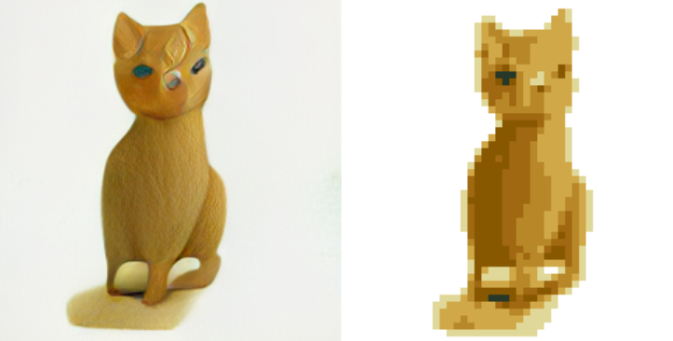

# Instructions:
First let's set up some variables. The cell below has a few variables that will determine how this notebook runs.

- If you are using your Stanford account set `use_dalle_mega=False`. If you are using the DallE Alchemist gmail account, and you want to use DallE Mega set `use_dalle_mega=True`. 

- Set your name flag to be `True` and other names to be `False`. For example, if Annie is running this notebook you should have `Annie=True Cole=False Rita=False` below. This will determine the folder path. 

- If you are using the DallE Alchemist gmail account, Rita's folder path is the one that works. So do `Annie=False Cole=False Rita=True` below.

Once the variables below are set, scroll all the way down to the "🎨 Generate images" cell to run all the setup cells in one click. Don't run any one cell manually yet!

In [1]:
# Using clip will associate a score with every image
# If using clip do so at your own risk, I haven't tested this extensively 
use_clip = False

# If this is set to False Dall-E mini will be used
use_dalle_mega = False

# Who are you?
Annie = True
Cole = False
Rita = False

# Setup Folder Paths
# For Annie 
if Annie:
  Dalle_folder = "/content/drive/MyDrive/CS 247G/Project 2: The Dall-E Alchemist/Dall-E/"
# For Cole
if Cole:
  Dalle_folder = "/content/drive/MyDrive/Shared/Project 2: The Dall-E Alchemist/Dall-E/"
# For Rita
if Rita:
  Dalle_folder = "/content/drive/MyDrive/Project 2: The Dall-E Alchemist/Dall-E/"

## 🛠️ Installation and set-up

In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
FOLDERNAME = Dalle_folder
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append(Dalle_folder)
folder_path = Dalle_folder
print(folder_path)

Mounted at /content/drive
/content/drive/MyDrive/CS 247G/Project 2: The Dall-E Alchemist/Dall-E/


In [3]:
# Install required libraries
# Takes ~1min
# # Ignore pip dependencies error 
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git
!pip install -q git+https://github.com/borisdayma/dalle-mini.git
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install git+https://github.com/sedthh/pyxelate.git --upgrade

     |████████████████████████████████| 190 kB 4.9 MB/s 
     |████████████████████████████████| 4.2 MB 60.9 MB/s 
     |████████████████████████████████| 140 kB 54.5 MB/s 
     |████████████████████████████████| 72 kB 650 kB/s 
     |████████████████████████████████| 6.6 MB 53.5 MB/s 
     |████████████████████████████████| 86 kB 5.5 MB/s 
     |████████████████████████████████| 596 kB 64.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 235 kB 9.9 MB/s 
     |████████████████████████████████| 175 kB 63.2 MB/s 
     |████████████████████████████████| 1.8 MB 57.8 MB/s 
     |████████████████████████████████| 145 kB 59.6 MB/s 
     |████████████████████████████████| 181 kB 72.6 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build

We load required models:
* dalle·mini for text to encoded images
* VQGAN for decoding images
* CLIP for scoring predictions

In [4]:
# Model references

if use_dalle_mega:
  # dalle-mega
  DALLE_MODEL = "dalle-mini/dalle-mini/mega-1-fp16:latest"
  DALLE_MODEL = "dalle-mini/dalle-mini/mega-1:v12"
else:
  # dalle-mini
  DALLE_MODEL = "dalle-mini/dalle-mini/mini-1:v0"  
DALLE_COMMIT_ID = None

# VQGAN model
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

In [5]:
import jax
import jax.numpy as jnp

# check how many devices are available
jax.local_device_count()

1

## Important: Read this
This cell will request a token the first time you run the notebook. wait for it to print a link. Open the link and create an account with "Weights and Biases". Then copy paste the token in the prompt and press enter. 

Note: when creating the account, it will ask you to create a team. Just press skip.

In [6]:
# This takes ~3 min with Dall-E Mega: Downloads 5GB
# This takes ~1 min with Dall-E Mini: Downloads 2GB

# Load models & tokenizer
from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel


# Load dalle-mini
model, params = DalleBart.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False)

# Load VQGAN
vqgan = VQModel.from_pretrained(VQGAN_REPO, revision=VQGAN_COMMIT_ID)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Downloading large artifact mini-1:v0, 1673.43MB. 7 files... Done. 0:0:0


Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/290M [00:00<?, ?B/s]

In [7]:
# This takes ~1-2 min if using clip
if use_clip:
  # CLIP model
  CLIP_REPO = "openai/clip-vit-large-patch14"
  CLIP_COMMIT_ID = None
  from transformers import CLIPProcessor, FlaxCLIPModel
  # Load CLIP
  clip = FlaxCLIPModel.from_pretrained(CLIP_REPO, revision=CLIP_COMMIT_ID)
  clip_processor = CLIPProcessor.from_pretrained(CLIP_REPO, revision=CLIP_COMMIT_ID)

Model parameters are replicated on each device for faster inference.

In [8]:
from flax.jax_utils import replicate

params = replicate(params)
vqgan._params = replicate(vqgan.params)
if use_clip:
  clip._params = replicate(clip.params)

Model functions are compiled and parallelized to take advantage of multiple devices.

In [9]:
from functools import partial

# model inference
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    return model.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )


# decode image
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

if use_clip:
  # score images
  @partial(jax.pmap, axis_name="batch")
  def p_clip(inputs, params):
      logits = clip(params=params, **inputs).logits_per_image
      return logits

Our model requires processing prompts.

In [10]:
# This takes ~15s
from dalle_mini import DalleBartProcessor

processor = DalleBartProcessor.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)

wandb: Downloading large artifact mini-1:v0, 1673.43MB. 7 files... Done. 0:0:0


Downloading:   0%|          | 0.00/34.2M [00:00<?, ?B/s]

### Function wrapper for generating images

In [11]:
from IPython.core.display import display_html
from flax.training.common_utils import shard
from flax.training.common_utils import shard_prng_key
from tqdm.notebook import trange
from pyxelate import Pyx, Pal
from skimage import io
from PIL import Image
import numpy as np
import random

def pixelate_img(image, pix_args, filename, idx, save, img_folder, is_display):
  # image = io.imread(img_path)  
  image = np.array(image)
  factor = pix_args["factor"]
  palette = pix_args["palette"]
  dither = pix_args["dither"]
  upscale = pix_args["upscale"]
  alpha = pix_args["alpha"]
  pix_img = Pyx(factor=factor, palette=palette, dither=dither, upscale=upscale, alpha=alpha).fit_transform(image)
  print("Pixelated image:")
  pix_img = Image.fromarray(pix_img, 'RGB')
  if is_display:
    display(pix_img)
  img_filename = filename + "_pixelated_" + str(idx)+ ".png"
  # io.imsave(img_folder+img_filename, )
  if save:
    pix_img.save(img_folder+img_filename, format="png")

def get_images(prompt, n_predictions, img_folder, filename=None, pixelate=False, pix_args=None, save=False, is_display=False):
  # Create random key
  seed = random.randint(0, 2**32 - 1)
  key = jax.random.PRNGKey(seed)
  # Process prompt
  tokenized_prompt = processor([prompt])
  # Replicate prompt on each device
  tokenized_prompt = replicate(tokenized_prompt)
  # We can customize top_k/top_p used for generating samples
  gen_top_k = None
  gen_top_p = None
  temperature = None
  cond_scale = 3.0

  # generate images
  images = []
  for i in trange(max(n_predictions // jax.device_count(), 1)):
      # get a new key
      key, subkey = jax.random.split(key)
      # generate images
      encoded_images = p_generate(
          tokenized_prompt,
          shard_prng_key(subkey),
          params,
          gen_top_k,
          gen_top_p,
          temperature,
          cond_scale,
      )
      # remove BOS
      encoded_images = encoded_images.sequences[..., 1:]
      # decode images
      decoded_images = p_decode(encoded_images, vqgan.params)
      decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
      for img in decoded_images:
          images.append(Image.fromarray(np.asarray(img * 255, dtype=np.uint8)))

  if use_clip:
    # get clip scores
    clip_inputs = clip_processor(
        text=[prompt] * jax.device_count(),
        images=images,
        return_tensors="np",
        padding="max_length",
        max_length=77,
        truncation=True,
    ).data
    logits = p_clip(shard(clip_inputs), clip.params)
    logits = logits.squeeze().flatten()

  # If filename is not specified replace spaces in prompt with "_"
  if filename is None:
    filename_separated = prompt.split()
    filename = "_".join(filename_separated)

  # Display and save images
  print(f"Prompt: {prompt}\n")
  if use_clip: # sort from highest to lowest clip score
    for idx in logits.argsort()[::-1]:
        if is_display:
          display(images[idx])
        print(f"Score: {logits[idx]:.2f}\n")
        img_filename = filename + "_img_" + str(idx)+ ".png"
        img_path = img_folder+img_filename
        if save:
          images[idx].save(img_path, format="png")
        if pixelate:
          pixelate_img(images[idx], pix_args, filename, idx, save, img_folder, is_display)
  else:
    for idx in range(len(images)):
        if is_display:
          display(images[idx])
        img_filename = filename + "_img_" + str(idx)+ ".png"
        img_path = img_folder+img_filename
        if save:
          images[idx].save(img_path, format="png")
        if pixelate:
          pixelate_img(images[idx], pix_args, filename, idx, save, img_folder, is_display)

/usr/local/lib/python3.7/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


# 🎨 Generate images

### Run Setup
To run all the setup cells, click on the code cell below, then click on Runtime in the top bar and press "Run Before". This will run all the previous cells one by one.

The setup cells should take about 5min to run but you only have to run them once! You have to rerun the setup cells each time you open the notebook.

### Image Generator
The code cells below offer different ways to generate images. You can input a prompt or a list of prompts and you can input a list of words that will be combined. Each Cell below will have a description of what it does with instructions on how to run it and where to find the outputs.

### Note on Pixelator:

You can select to pixelate the generated images. The pixelating function takes a few arguments. To learn what each argument does, see documentation here: https://github.com/sedthh/pyxelate#hyperparameters-for-pyx

You can also just run with the default values and it'll work fine.



# Generate from a Prompt: Use this for testing
The cell below lets you generate images for 1 prompt:

- Replace the text for prompt with your own prompt e.g. `prompt = "wooden cat"`
- Set the number of images you would like generated for that prompt
- Set the folder where you want the images saved. Make sure the folder exists in the Dall-E folder
- If you want the outputs to be pixelated set `pixelate=True`. The pixelated images will be saved in the same folder as the images.
- Set `is_display=True` if you want the outputs to be displayed here. The outputs will be saved in specified folder even if not displayed.
- Hover over the code and press the play button on the upper left of the code cell.

The function that generates the images is random, so each time you run the cell below, you will get different outputs.

Keep scrolling for cells that take multiple prompts.



  0%|          | 0/16 [00:00<?, ?it/s]

Prompt: cinnamon tea game asset artstation, cinnamon tea in a cup



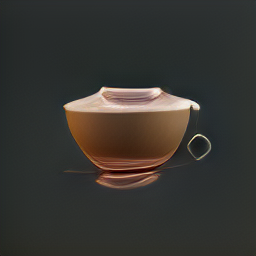

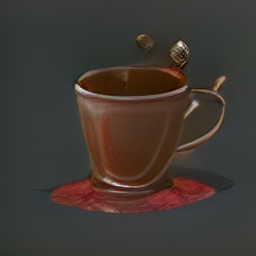

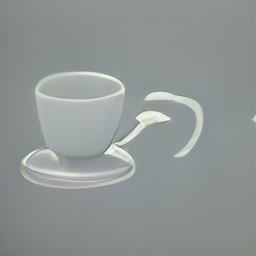

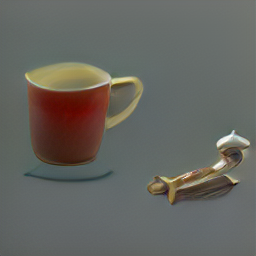

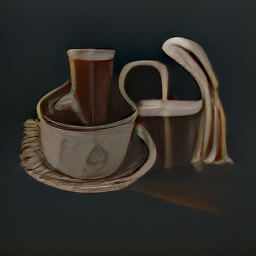

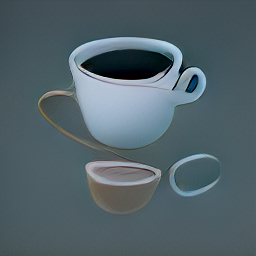

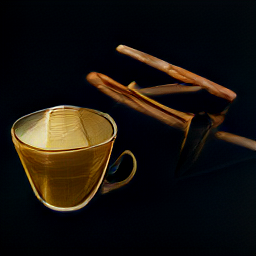

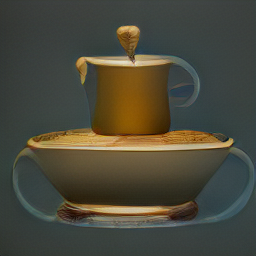

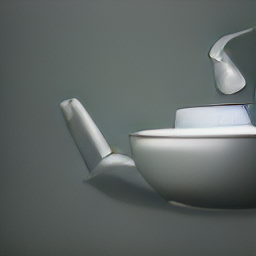

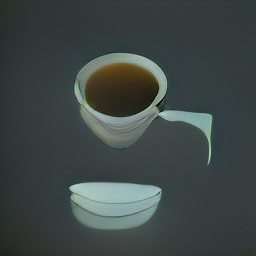

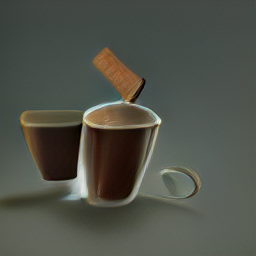

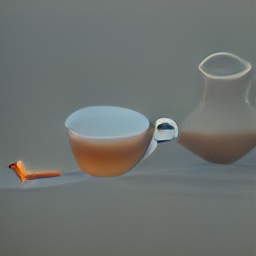

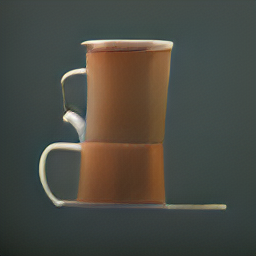

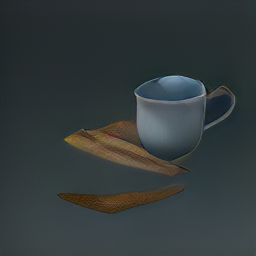

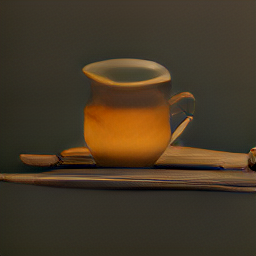

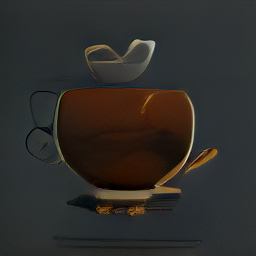

In [ ]:
# Write your prompt here
prompt = "cinnamon tea game asset artstation, cinnamon tea in a cup"

# Set up drive folder path: this is where images will be saved
img_folder = Dalle_folder + "images2/"
if Rita:
  img_folder = Dalle_folder + "rita_images/"
if Annie:
  img_folder = Dalle_folder + "annie_generated_images/"


# Set this to True if you want the images to be saved in the images folder
# If you are experimenting set this to False to not use up a lot of memory!
save = True

# If you want the outputs displayed set this to True
is_display = True

# Write the number of images you want generated
# Dall-E Mini takes <5s per image
# Dall-E Mega takes ~30s per image
num_images = 16

# Set this to False if you don't want pixelated images
pixelate = False
# These are the arguments for the pixelating function
pix_args = {"factor":5, "palette":10, "dither":"naive", "upscale":5, "alpha":.6}

# This will generate and display the images!
get_images(prompt, num_images, img_folder, pixelate=pixelate, pix_args=pix_args, save=save, is_display=is_display)

## Generate Multiple Prompts:

- Edit the prompts list for all the prompts you'd like generated. 

All other variables work as in the previous cell

In [ ]:
img_folder = Dalle_folder + "images/"

prompts = [
           "a candy cane sword", 
           "a cube made out of green grass", 
           "a hat made out of bread",
           ]

save = False
num_images = 4
is_display = False

pixelate = True
pix_args = {"factor":5, "palette":7, "dither":"naive", "upscale":5, "alpha":.6}

for p in prompts:
  get_images(p, num_images, img_folder, pixelate=pixelate, pix_args=pix_args, save=save, is_display=is_display)
  

NameError: ignored

## Extra Arguments Control

Modify the prompts and number of images to control how many images are generated per prompt.

In [ ]:
img_folder = Dalle_folder + "images/"

prompts = [
           "wooden cat", 
           "plastic dog", 
           ]

num_imgs = [1, 2]

save = False
pixelate = True
is_display=False
pix_args = {"factor":5, "palette":7, "dither":"naive", "upscale":5, "alpha":.6}

## Optional: 
# You can specify the filename of the saved image
# Pass this list as a third argument (add to zip and get individual elements)
filenames = ["wood_cat", "plastic_dog"]
# This can be helpful later on to organize image names from cards combined

for p, n, f in zip(prompts, num_imgs, filenames):
  get_images(p, n, img_folder, filename=f, pixelate=pixelate, pix_args=pix_args, save=save, is_display=is_display)

## Generate Word Combos

This cell will generate prompts for all word combinations:
- Set words to be the list of items you'd like combined e.g. `words=["barrel", "cherry"]`
- Set combinations to define the way in which you'd like the words to be combined. There can be multiple instances of 1 and 2 in your combinations. If `combinations=["1 2", "1 on top of 2"]` the cell will generate: 

`["barrel barrel", "barrel cherry", "cherry cherry", "cherry barrel", "barrel on top of barrel", "barrel on top of cherry", "cherry on top of cherry", "cherry on top of barrel"]`. 
- Set `num_per_combination` to be how many generated images you want per combination. If `num_per_combination=[3, 1]` then you will have 3 generated images for each of `["barrel cherry", "cherry barrel", ...]` and 1 generated image for each of `["barrel on top of cherry", "cherry on top of barrel", ...]`.

The cell will print all the generated prompts. Look at them to make sure they look right. 

This cell will also print an approximation of how much time it will take to generate all the images depending on if you're using Dall-E Mini or Mega.

Note: For our own separate parts, we can each have a list of words and another list of combinations in this cell. Don't delete other people's list just comment it out (use # at the beginning of the line) and add yours!

In [13]:
import datetime
# The words list will be used to create every possible combination and pass it through Dall-E
# The combinations will include different orderings i.e. "barrel bush" and "bush barrel"
#words = ["barrel", "cherry", "flowers", "lamp", "mushroom", "television"]

# Rita
#words = ["sand", "dollar", "wrench", "crab", "seashell", "screwdriver", "star", "fish", "hammer", "coconut", "crab"]

# Annie
words = ["sapphire, sword, blueberry, redberry, apple, water, cinnamon"]
combinations = [
                "1 2",
                "1 2 game asset artstation, a 2 in the shape of a 1", 
                "1 2, 2 in the shape of a 1, 1 made out of 2", 
#                "2 on top of a 1",
                ]


# The combinations list is used to define how to combine words
# 1 and 2 will be replaced by all possible words in all possible orderings
# combinations = [
#                 "1 2 game asset artstation, a 2 in the shape of a 1", 
#                 "1 2 artstation, a 2 in the shape of a 1",
#                 "1 2 artstation, a hybrid of a 1 and a 2",
#                 "1 2, a 2 in the shape of a 1", 
#                 "1 2, a 2 made out of 1",
#                 "2 on top of a 1",
#                 "1 with a 2, 1 next to a 2, an image containing a 1 and a 2"
#                 ]

# Define the number of generated images desired per combination
num_per_combination = [3, 6, 3]

num_imgs = []
prompts = []
folders = []
subfolders = []

# Make word combinations
for i in range(len(words)):
  for j in range(len(words)):
    print("______________________________________________________")

    # Add extras
    for k, s in enumerate(combinations):
      while(s.find("1")!=-1):
        idx = s.find("1")
        s =  s[:idx] + words[i] + s[idx+1:]
      while(s.find("2")!=-1):
        idx = s.find("2")
        s =  s[:idx] + words[j] + s[idx+1:]
      print("i = ", i, " j = ", j, " k = ", k, " Prompt = ", s)
      folders.append(words[i])
      subfolders.append(words[j])
      prompts.append(s)
      num_imgs.append(num_per_combination[k])

assert len(prompts)==len(num_imgs)
print("______________________________________________________")
print("Total number of prompts = ", len(prompts))
print("Total number of images to be generated = ", sum(num_imgs))
time = sum(num_imgs)*30
print("Assuming 30s/image, Dall-E Mega will take ", str(datetime.timedelta(seconds=time)))
time = sum(num_imgs)*5
print("Assuming 5s/image, Dall-E Mini will take ", str(datetime.timedelta(seconds=time)))

______________________________________________________
i =  0  j =  0  k =  0  Prompt =  sapphire, sword, blueberry, redberry, apple, water, cinnamon sapphire, sword, blueberry, redberry, apple, water, cinnamon
i =  0  j =  0  k =  1  Prompt =  sapphire, sword, blueberry, redberry, apple, water, cinnamon sapphire, sword, blueberry, redberry, apple, water, cinnamon game asset artstation, a sapphire, sword, blueberry, redberry, apple, water, cinnamon in the shape of a sapphire, sword, blueberry, redberry, apple, water, cinnamon
i =  0  j =  0  k =  2  Prompt =  sapphire, sword, blueberry, redberry, apple, water, cinnamon sapphire, sword, blueberry, redberry, apple, water, cinnamon, sapphire, sword, blueberry, redberry, apple, water, cinnamon in the shape of a sapphire, sword, blueberry, redberry, apple, water, cinnamon, sapphire, sword, blueberry, redberry, apple, water, cinnamon made out of sapphire, sword, blueberry, redberry, apple, water, cinnamon
____________________________________

Once you are satisfied with the prompts above, run the cell below to generate images.

The cell below will generate images and save them in a tree-like folder ordering. Following the example from the previous cell, you will have two folders `barrel` and `cherry` and within the `barrel` folder, you will find `barrel/barrel` and `barrel/cherry`. The images created from combining `barrel --> 1` and `cherry --> 2` will be under `barrel/cherry`.

If the cell below crashes in the middle of generating images, read the instructions commented above `start_prompt` to pick up from where the code last stopped.

**Important:** it is advisable to not display and not pixelate yet. It takes more time to do so. You can see the saved images in the folders, pick the ones you like and put them under the `to_pixelate` folder. Scroll down for more info on how to pixelate a batch of images.


In [ ]:
# If this crashed while generating images, replace start_prompt with the last 
# prompt used to generate images and it will start from there
# e.g. 
# start_prompt = "coconut on top of a dollar"
# If start_prompt is None it will not look for a starting prompt
start_prompt = None

if start_prompt is not None:
  idx = prompts.index(start_prompt)
  prompts = prompts[idx:]
  num_imgs = num_imgs[idx:]
  folders = folders[idx:]
  subfolders = subfolders[idx:]

import os
if Rita:
  img_folder = Dalle_folder+"/rita_images/"
else:
  img_folder = Dalle_folder+"/generated_images/"

save = True
pixelate = False

# Define custom Palette (replace palette value in pix_args with my_pal)
my_pal = Pal.from_hex(["#55efc4", "#81ecec", "#74b9ff", "#a29bfe", "#dfe6e9",
                       "#00b894", "#00cec9", "#0984e3", "#6c5ce7", "#b2bec3",
                       "#ffeaa7", "#fab1a0", "#ff7675", "#fd79a8", "#636e72",
                       "#fdcb6e", "#e17055", "#d63031", "#e84393", "#2d3436",])

# Use predicted palette:
palette = 7

pix_args = {"factor":5, "palette":palette, "dither":"none", "upscale":5, "alpha":.6}

for p, n, f, subf in zip(prompts, num_imgs, folders, subfolders):
  # Create subfolder if it doesn't exist already:
  curr_img_folder = img_folder + f + "/" + subf + "/"
  isExist = os.path.exists(curr_img_folder)
  if not isExist:
    os.makedirs(curr_img_folder)
  # Generate images
  get_images(p, n, curr_img_folder, pixelate=pixelate, pix_args=pix_args, save=save, is_display=False)

  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand sand game asset artstation, a sand in the shape of a sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand sand, sand in the shape of a sand, sand made out of sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand on top of a sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand dollar game asset artstation, a dollar in the shape of a sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand dollar, dollar in the shape of a sand, sand made out of dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar on top of a sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand wrench game asset artstation, a wrench in the shape of a sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand wrench, wrench in the shape of a sand, sand made out of wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench on top of a sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand crab game asset artstation, a crab in the shape of a sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand crab, crab in the shape of a sand, sand made out of crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab on top of a sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand seashell game asset artstation, a seashell in the shape of a sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand seashell, seashell in the shape of a sand, sand made out of seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell on top of a sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand screwdriver game asset artstation, a screwdriver in the shape of a sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand screwdriver, screwdriver in the shape of a sand, sand made out of screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver on top of a sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand star game asset artstation, a star in the shape of a sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand star, star in the shape of a sand, sand made out of star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star on top of a sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand fish game asset artstation, a fish in the shape of a sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand fish, fish in the shape of a sand, sand made out of fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish on top of a sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand hammer game asset artstation, a hammer in the shape of a sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand hammer, hammer in the shape of a sand, sand made out of hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer on top of a sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand coconut game asset artstation, a coconut in the shape of a sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand coconut, coconut in the shape of a sand, sand made out of coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut on top of a sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand crab game asset artstation, a crab in the shape of a sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand crab, crab in the shape of a sand, sand made out of crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab on top of a sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar sand game asset artstation, a sand in the shape of a dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar sand, sand in the shape of a dollar, dollar made out of sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand on top of a dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar dollar game asset artstation, a dollar in the shape of a dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar dollar, dollar in the shape of a dollar, dollar made out of dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar on top of a dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar wrench game asset artstation, a wrench in the shape of a dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar wrench, wrench in the shape of a dollar, dollar made out of wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench on top of a dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar crab game asset artstation, a crab in the shape of a dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar crab, crab in the shape of a dollar, dollar made out of crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab on top of a dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar seashell game asset artstation, a seashell in the shape of a dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar seashell, seashell in the shape of a dollar, dollar made out of seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell on top of a dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar screwdriver game asset artstation, a screwdriver in the shape of a dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar screwdriver, screwdriver in the shape of a dollar, dollar made out of screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver on top of a dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar star game asset artstation, a star in the shape of a dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar star, star in the shape of a dollar, dollar made out of star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star on top of a dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar fish game asset artstation, a fish in the shape of a dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar fish, fish in the shape of a dollar, dollar made out of fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish on top of a dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar hammer game asset artstation, a hammer in the shape of a dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar hammer, hammer in the shape of a dollar, dollar made out of hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer on top of a dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar coconut game asset artstation, a coconut in the shape of a dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar coconut, coconut in the shape of a dollar, dollar made out of coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut on top of a dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar crab game asset artstation, a crab in the shape of a dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar crab, crab in the shape of a dollar, dollar made out of crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab on top of a dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench sand game asset artstation, a sand in the shape of a wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench sand, sand in the shape of a wrench, wrench made out of sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand on top of a wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench dollar game asset artstation, a dollar in the shape of a wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench dollar, dollar in the shape of a wrench, wrench made out of dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar on top of a wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench wrench game asset artstation, a wrench in the shape of a wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench wrench, wrench in the shape of a wrench, wrench made out of wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench on top of a wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench crab game asset artstation, a crab in the shape of a wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench crab, crab in the shape of a wrench, wrench made out of crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab on top of a wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench seashell game asset artstation, a seashell in the shape of a wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench seashell, seashell in the shape of a wrench, wrench made out of seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell on top of a wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench screwdriver game asset artstation, a screwdriver in the shape of a wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench screwdriver, screwdriver in the shape of a wrench, wrench made out of screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver on top of a wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench star game asset artstation, a star in the shape of a wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench star, star in the shape of a wrench, wrench made out of star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star on top of a wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench fish game asset artstation, a fish in the shape of a wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench fish, fish in the shape of a wrench, wrench made out of fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish on top of a wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench hammer game asset artstation, a hammer in the shape of a wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench hammer, hammer in the shape of a wrench, wrench made out of hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer on top of a wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench coconut game asset artstation, a coconut in the shape of a wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench coconut, coconut in the shape of a wrench, wrench made out of coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut on top of a wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench crab game asset artstation, a crab in the shape of a wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench crab, crab in the shape of a wrench, wrench made out of crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab on top of a wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab sand game asset artstation, a sand in the shape of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab sand, sand in the shape of a crab, crab made out of sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand on top of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab dollar game asset artstation, a dollar in the shape of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab dollar, dollar in the shape of a crab, crab made out of dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar on top of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab wrench game asset artstation, a wrench in the shape of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab wrench, wrench in the shape of a crab, crab made out of wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench on top of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab crab game asset artstation, a crab in the shape of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab crab, crab in the shape of a crab, crab made out of crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab on top of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab seashell game asset artstation, a seashell in the shape of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab seashell, seashell in the shape of a crab, crab made out of seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell on top of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab screwdriver game asset artstation, a screwdriver in the shape of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab screwdriver, screwdriver in the shape of a crab, crab made out of screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver on top of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab star game asset artstation, a star in the shape of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab star, star in the shape of a crab, crab made out of star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star on top of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab fish game asset artstation, a fish in the shape of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab fish, fish in the shape of a crab, crab made out of fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish on top of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab hammer game asset artstation, a hammer in the shape of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab hammer, hammer in the shape of a crab, crab made out of hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer on top of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab coconut game asset artstation, a coconut in the shape of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab coconut, coconut in the shape of a crab, crab made out of coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut on top of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab crab game asset artstation, a crab in the shape of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab crab, crab in the shape of a crab, crab made out of crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab on top of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell sand game asset artstation, a sand in the shape of a seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell sand, sand in the shape of a seashell, seashell made out of sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand on top of a seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell dollar game asset artstation, a dollar in the shape of a seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell dollar, dollar in the shape of a seashell, seashell made out of dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar on top of a seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell wrench game asset artstation, a wrench in the shape of a seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell wrench, wrench in the shape of a seashell, seashell made out of wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench on top of a seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell crab game asset artstation, a crab in the shape of a seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell crab, crab in the shape of a seashell, seashell made out of crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab on top of a seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell seashell game asset artstation, a seashell in the shape of a seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell seashell, seashell in the shape of a seashell, seashell made out of seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell on top of a seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell screwdriver game asset artstation, a screwdriver in the shape of a seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell screwdriver, screwdriver in the shape of a seashell, seashell made out of screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver on top of a seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell star game asset artstation, a star in the shape of a seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell star, star in the shape of a seashell, seashell made out of star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star on top of a seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell fish game asset artstation, a fish in the shape of a seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell fish, fish in the shape of a seashell, seashell made out of fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish on top of a seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell hammer game asset artstation, a hammer in the shape of a seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell hammer, hammer in the shape of a seashell, seashell made out of hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer on top of a seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell coconut game asset artstation, a coconut in the shape of a seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell coconut, coconut in the shape of a seashell, seashell made out of coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut on top of a seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell crab game asset artstation, a crab in the shape of a seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell crab, crab in the shape of a seashell, seashell made out of crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab on top of a seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver sand game asset artstation, a sand in the shape of a screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver sand, sand in the shape of a screwdriver, screwdriver made out of sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand on top of a screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver dollar game asset artstation, a dollar in the shape of a screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver dollar, dollar in the shape of a screwdriver, screwdriver made out of dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar on top of a screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver wrench game asset artstation, a wrench in the shape of a screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver wrench, wrench in the shape of a screwdriver, screwdriver made out of wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench on top of a screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver crab game asset artstation, a crab in the shape of a screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver crab, crab in the shape of a screwdriver, screwdriver made out of crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab on top of a screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver seashell game asset artstation, a seashell in the shape of a screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver seashell, seashell in the shape of a screwdriver, screwdriver made out of seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell on top of a screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver screwdriver game asset artstation, a screwdriver in the shape of a screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver screwdriver, screwdriver in the shape of a screwdriver, screwdriver made out of screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver on top of a screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver star game asset artstation, a star in the shape of a screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver star, star in the shape of a screwdriver, screwdriver made out of star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star on top of a screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver fish game asset artstation, a fish in the shape of a screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver fish, fish in the shape of a screwdriver, screwdriver made out of fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish on top of a screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver hammer game asset artstation, a hammer in the shape of a screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver hammer, hammer in the shape of a screwdriver, screwdriver made out of hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer on top of a screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver coconut game asset artstation, a coconut in the shape of a screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver coconut, coconut in the shape of a screwdriver, screwdriver made out of coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut on top of a screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver crab game asset artstation, a crab in the shape of a screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver crab, crab in the shape of a screwdriver, screwdriver made out of crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab on top of a screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star sand game asset artstation, a sand in the shape of a star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star sand, sand in the shape of a star, star made out of sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand on top of a star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star dollar game asset artstation, a dollar in the shape of a star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star dollar, dollar in the shape of a star, star made out of dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar on top of a star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star wrench game asset artstation, a wrench in the shape of a star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star wrench, wrench in the shape of a star, star made out of wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench on top of a star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star crab game asset artstation, a crab in the shape of a star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star crab, crab in the shape of a star, star made out of crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab on top of a star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star seashell game asset artstation, a seashell in the shape of a star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star seashell, seashell in the shape of a star, star made out of seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell on top of a star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star screwdriver game asset artstation, a screwdriver in the shape of a star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star screwdriver, screwdriver in the shape of a star, star made out of screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver on top of a star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star star game asset artstation, a star in the shape of a star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star star, star in the shape of a star, star made out of star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star on top of a star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star fish game asset artstation, a fish in the shape of a star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star fish, fish in the shape of a star, star made out of fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish on top of a star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star hammer game asset artstation, a hammer in the shape of a star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star hammer, hammer in the shape of a star, star made out of hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer on top of a star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star coconut game asset artstation, a coconut in the shape of a star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star coconut, coconut in the shape of a star, star made out of coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut on top of a star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star crab game asset artstation, a crab in the shape of a star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star crab, crab in the shape of a star, star made out of crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab on top of a star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish sand game asset artstation, a sand in the shape of a fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish sand, sand in the shape of a fish, fish made out of sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand on top of a fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish dollar game asset artstation, a dollar in the shape of a fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish dollar, dollar in the shape of a fish, fish made out of dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar on top of a fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish wrench game asset artstation, a wrench in the shape of a fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish wrench, wrench in the shape of a fish, fish made out of wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench on top of a fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish crab game asset artstation, a crab in the shape of a fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish crab, crab in the shape of a fish, fish made out of crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab on top of a fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish seashell game asset artstation, a seashell in the shape of a fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish seashell, seashell in the shape of a fish, fish made out of seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell on top of a fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish screwdriver game asset artstation, a screwdriver in the shape of a fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish screwdriver, screwdriver in the shape of a fish, fish made out of screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver on top of a fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish star game asset artstation, a star in the shape of a fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish star, star in the shape of a fish, fish made out of star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star on top of a fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish fish game asset artstation, a fish in the shape of a fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish fish, fish in the shape of a fish, fish made out of fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish on top of a fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish hammer game asset artstation, a hammer in the shape of a fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish hammer, hammer in the shape of a fish, fish made out of hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer on top of a fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish coconut game asset artstation, a coconut in the shape of a fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish coconut, coconut in the shape of a fish, fish made out of coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut on top of a fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish crab game asset artstation, a crab in the shape of a fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish crab, crab in the shape of a fish, fish made out of crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab on top of a fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer sand game asset artstation, a sand in the shape of a hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer sand, sand in the shape of a hammer, hammer made out of sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand on top of a hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer dollar game asset artstation, a dollar in the shape of a hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer dollar, dollar in the shape of a hammer, hammer made out of dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar on top of a hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer wrench game asset artstation, a wrench in the shape of a hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer wrench, wrench in the shape of a hammer, hammer made out of wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench on top of a hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer crab game asset artstation, a crab in the shape of a hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer crab, crab in the shape of a hammer, hammer made out of crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab on top of a hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer seashell game asset artstation, a seashell in the shape of a hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer seashell, seashell in the shape of a hammer, hammer made out of seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell on top of a hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer screwdriver game asset artstation, a screwdriver in the shape of a hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer screwdriver, screwdriver in the shape of a hammer, hammer made out of screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver on top of a hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer star game asset artstation, a star in the shape of a hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer star, star in the shape of a hammer, hammer made out of star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star on top of a hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer fish game asset artstation, a fish in the shape of a hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer fish, fish in the shape of a hammer, hammer made out of fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish on top of a hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer hammer game asset artstation, a hammer in the shape of a hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer hammer, hammer in the shape of a hammer, hammer made out of hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer on top of a hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer coconut game asset artstation, a coconut in the shape of a hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer coconut, coconut in the shape of a hammer, hammer made out of coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut on top of a hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer crab game asset artstation, a crab in the shape of a hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer crab, crab in the shape of a hammer, hammer made out of crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab on top of a hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut sand game asset artstation, a sand in the shape of a coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut sand, sand in the shape of a coconut, coconut made out of sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand on top of a coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut dollar game asset artstation, a dollar in the shape of a coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut dollar, dollar in the shape of a coconut, coconut made out of dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar on top of a coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut wrench game asset artstation, a wrench in the shape of a coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut wrench, wrench in the shape of a coconut, coconut made out of wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench on top of a coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut crab game asset artstation, a crab in the shape of a coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut crab, crab in the shape of a coconut, coconut made out of crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab on top of a coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut seashell game asset artstation, a seashell in the shape of a coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut seashell, seashell in the shape of a coconut, coconut made out of seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell on top of a coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut screwdriver game asset artstation, a screwdriver in the shape of a coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut screwdriver, screwdriver in the shape of a coconut, coconut made out of screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver on top of a coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut star game asset artstation, a star in the shape of a coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut star, star in the shape of a coconut, coconut made out of star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star on top of a coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut fish game asset artstation, a fish in the shape of a coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut fish, fish in the shape of a coconut, coconut made out of fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish on top of a coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut hammer game asset artstation, a hammer in the shape of a coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut hammer, hammer in the shape of a coconut, coconut made out of hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer on top of a coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut coconut game asset artstation, a coconut in the shape of a coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut coconut, coconut in the shape of a coconut, coconut made out of coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut on top of a coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut crab game asset artstation, a crab in the shape of a coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut crab, crab in the shape of a coconut, coconut made out of crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab on top of a coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab sand game asset artstation, a sand in the shape of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab sand, sand in the shape of a crab, crab made out of sand



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: sand on top of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab dollar game asset artstation, a dollar in the shape of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab dollar, dollar in the shape of a crab, crab made out of dollar



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: dollar on top of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab wrench game asset artstation, a wrench in the shape of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab wrench, wrench in the shape of a crab, crab made out of wrench



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: wrench on top of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab crab game asset artstation, a crab in the shape of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab crab, crab in the shape of a crab, crab made out of crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab on top of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab seashell game asset artstation, a seashell in the shape of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab seashell, seashell in the shape of a crab, crab made out of seashell



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: seashell on top of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab screwdriver game asset artstation, a screwdriver in the shape of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab screwdriver, screwdriver in the shape of a crab, crab made out of screwdriver



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: screwdriver on top of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab star game asset artstation, a star in the shape of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab star, star in the shape of a crab, crab made out of star



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: star on top of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab fish game asset artstation, a fish in the shape of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab fish, fish in the shape of a crab, crab made out of fish



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: fish on top of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab hammer game asset artstation, a hammer in the shape of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab hammer, hammer in the shape of a crab, crab made out of hammer



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: hammer on top of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab coconut game asset artstation, a coconut in the shape of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab coconut, coconut in the shape of a crab, crab made out of coconut



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: coconut on top of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab crab game asset artstation, a crab in the shape of a crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab crab, crab in the shape of a crab, crab made out of crab



  0%|          | 0/8 [00:00<?, ?it/s]

Prompt: crab on top of a crab



# Pixelate Images in a Folder
This function takes a source folder and a destination folder. The function will pixelate every image in the source folder and put the pixelated images in the destination folder. The pixelate arguments work as in previous functions.

In [ ]:
from os import listdir
from os.path import isfile, join
from skimage import io
from pyxelate import Pyx, Pal
from PIL import Image
import numpy as np

def pixelate_img(img_path, pix_args): 
  image = io.imread(img_path)  
  factor = pix_args["factor"]
  palette = pix_args["palette"]
  dither = pix_args["dither"]
  upscale = pix_args["upscale"]
  alpha = pix_args["alpha"]
  pix_img = Pyx(factor=factor, palette=palette, dither=dither, upscale=upscale, alpha=alpha).fit_transform(image)
  pix_img = Image.fromarray(pix_img, 'RGB')
  return pix_img

def pixelate_folder(source, destination, pix_args):
  source_paths = [source+f for f in listdir(source) if isfile(join(source, f))]
  destination_paths = [destination+f[:-4]+"_pix"+f[-4:] for f in listdir(source) if isfile(join(source, f))]
  n = len(source_paths)
  i = 1
  for s, d in zip(source_paths, destination_paths):
    print("Pixelating image ", i, "/", n)
    pix_img = pixelate_img(s, pix_args)
    pix_img.save(d, format="png")
    i += 1



/usr/local/lib/python3.7/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


Read comments below and modify to create desired outputs

In [ ]:
# Define your source folder where the images to be pixelated are
source = Dalle_folder + "to_pixelate_rita/"
# Define your destination folder where you want the pixelated images to be saved
destination = Dalle_folder + "pixelated/"
destination = Dalle_folder + "to_pixelate_rita/"
# Define the pixelator arguments
pix_args = {"factor":5, "palette":10, "dither":"none", "upscale":5, "alpha":.6}


# Call pixelating function
pixelate_folder(source, destination, pix_args)

Pixelating image  1 / 1


/usr/local/lib/python3.7/dist-packages/pyxelate/pyx.py:84: Warning: Pyxelate could not properly assign colors, try a different palette size for better results!
  warnings.warn("Pyxelate could not properly assign colors, try a different palette size for better results!", Warning)
